# E-tivity 1 (Weeks 1-2)

* Barry Clarke

* 24325082

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv".

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Guidelines

The e-tivity is split into four tasks. The first three are "group" excersises, in that you post the solutions to Tasks 1-3 to a site. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to the Group Locker.

Marks will be deducted if task 4 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-4 and with correct identification or filename.

Grading guidelines: the scores for each task are additive. Below is a link to the E-tivity rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks



## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this e-tivity you will determining the anomalies by using an autoencoder. That is you will **not** be using the Anom flag to guide the training.

The mystery dataset is available from Brightspace, download the csv file and use it as the input data.

### Tasks 1-3 (complete by Sunday Week 2)

Create additional cells to implement the tasks below. These task form the group learning section of the E-tivity. As such it is encouraged that you post yuor notebook in the group locker.

Grading guidelines are given in the rubrics for the E-tivity

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

**Task 1: data preprocessing**

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.


**Task 2: model generation and training**

Generate a suitable autoencoder model, the only restriction is that there should be only 2 latent variables. Train the model to a satistifactory result. Be aware that it will be much harder to achieve the sort of result you can get from a supervised learning model.

**Hint**: it should not take longer than a 1000 epochs to train. However it may be difficult to train. Use different optimizers, topologies and/or weight initialisations to get convergence. Remember that achieving a perfect error means that the model will also be good at reconstructing anomalies.


**Task 3: anomaly detection**

From the histogram of the reconstruction error decide what the cutoff should be applied to distinguish anomalies from valid samples, given that the anomaly rate is ~7%.

### Post (complete by Sunday Week 1)

Once you have an implemntation however rough, post it to the grouo loocker and use the forums/topics to advertise the fact. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

No posts should refer to Task 4.

This forms part of the overall assessment for the E-tivity.

### Respond (complete by Wednesday Week 2)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

If you stick to the deadline then it will allow yourself and others to have enough time to implement suggestions. From the Schedule you can see that this is not a hard deadline.

The posts on the forum/topic associated with this e-tivity are graded. Below is a link to the rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

### Final Submission (complete by Sunday Week 2)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import random

In [18]:
# ==========================================
# Task 1: Data Preprocessing
# ==========================================

# Purely added for/during model refinement - will be removed once the architecture has been refined
#random.seed(42) # Set the python built-in pseudo-random generator at a fixed value
#np.random.seed(42) # Set the numpy pseudo-random generator at a fixed value
#tf.random.set_seed(42) # Set the tensorflow pseudo-random generator at a fixed value

# 1. Load the dataset
df = pd.read_csv('data.csv')
print("Dataset loaded successfully.")

# 2. Inspect the data
# Check dimensions and preview data structure
print(df.head())
print("Data shape:", df.shape)

# 3. Separate features and target
# Logic follows 'REF_DimRedComparison'; inputs (X) separated from target (y)
X = df.drop('Anom', axis=1) # 'Anom' dropped from X; forbidden for training by e-tivity instructions
y = df['Anom'] # 'y' retained  for post-training validation (Task 3)

# 4. Split into training and test sets
# Standard 80/20 split used (matching Ref Cell 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scale the data
# Scale the data with respect to the training data set
# StandardScaler applied (Mean=0, Variance=1); consistent with Ref Cell 4/5 (REF_DimRedComparison.ipynb)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Scaling the test set using the transform defined by the train set (as per REF_DimRedComparison.ipynb)

print("Training data shape:", X_train_scaled.shape)
print("Test data shape:", X_test_scaled.shape)

Dataset loaded successfully.
   V1  V2  V3  V4  V5  V6  V7  V8  V9  Anom
0  50  21  77   0  28   0  27  48  22     1
1  53   0  82   0  52  -5  29  30   2     0
2  37   0  76   0  28  18  40  48   8     0
3  37   0  79   0  34 -26  43  46   2     0
4  85   0  88  -4   6   1   3  83  80     1
Data shape: (49097, 10)
Training data shape: (39277, 9)
Test data shape: (9820, 9)


Starting Robust Training (Best of 5)...

--- Run 1 of 5 ---
  Epoch 10: loss=0.3687, val_loss=0.3093
  Epoch 20: loss=0.3472, val_loss=0.2869
  Epoch 30: loss=0.3413, val_loss=0.2831
  Epoch 40: loss=0.3018, val_loss=0.2548
  Epoch 50: loss=0.2838, val_loss=0.2531
Run 1 Finished. Best Loss: 0.2495

--- Run 2 of 5 ---
  Epoch 10: loss=0.3708, val_loss=0.3035
  Epoch 20: loss=0.3548, val_loss=0.2940
Run 2 Finished. Best Loss: 0.2927

--- Run 3 of 5 ---
  Epoch 10: loss=0.3482, val_loss=0.2894
  Epoch 20: loss=0.3201, val_loss=0.2706
  Epoch 30: loss=0.2638, val_loss=0.2499
  Epoch 40: loss=0.2350, val_loss=0.2442
  Epoch 50: loss=0.2137, val_loss=0.2357
  Epoch 60: loss=0.2016, val_loss=0.2338
  Epoch 70: loss=0.1914, val_loss=0.2348
  Epoch 80: loss=0.1853, val_loss=0.2300
Run 3 Finished. Best Loss: 0.2288

--- Run 4 of 5 ---
  Epoch 10: loss=0.3755, val_loss=0.3861
  Epoch 20: loss=0.3484, val_loss=0.3809
  Epoch 30: loss=0.3221, val_loss=0.3549
  Epoch 40: loss=0.2631, val_loss=0.3008

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 7)              │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 9)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 695 (2.72 KB)

 Trainable params: 231 (924.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 464 (1.82 KB)

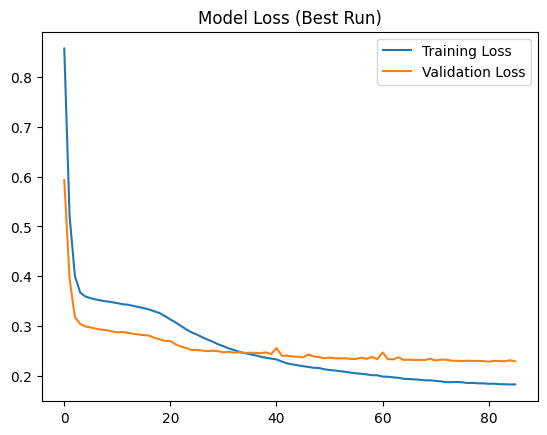

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Calculated Threshold (92nd Percentile): 0.0226


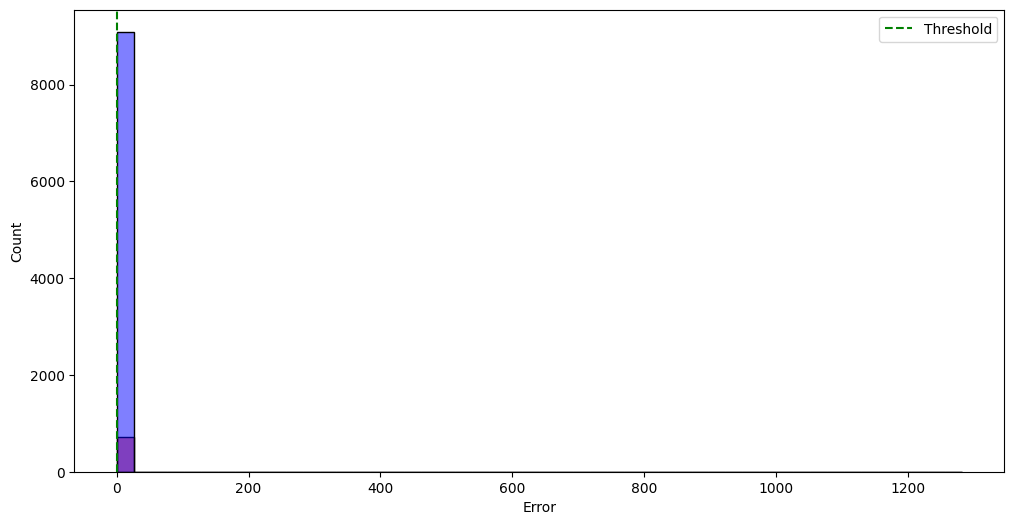


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9100
           1       0.71      0.78      0.75       720

    accuracy                           0.96      9820
   macro avg       0.85      0.88      0.86      9820
weighted avg       0.96      0.96      0.96      9820

Confusion Matrix:


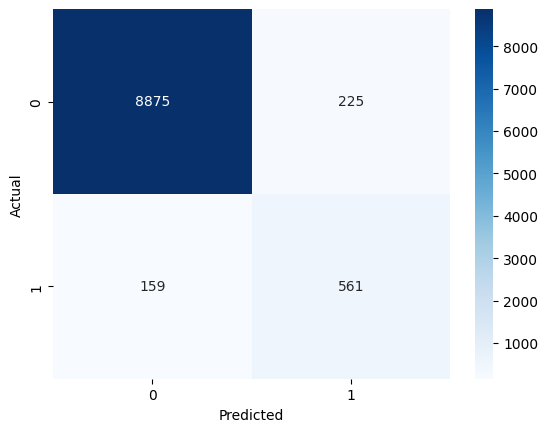

In [19]:
# ==========================================
# Task 2: Model Generation and Training
# (Implements "Best of 5" Strategy for Stability)
# ==========================================

# 1. Define the Helper to print every 10 epochs
# (Keeps the output clean while showing progress)
class PrintProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch + 1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

# 2. Setup Variables
input_dim = X_train_scaled.shape[1]
best_loss = float('inf')
best_model = None
best_history = None

print("Starting Training (Best of 5)...")
start_time = time.time()

# 3. The "Best of 5" Loop
for i in range(5):
    print(f"\n--- Run {i + 1} of 5 ---")

    # Build architecture (Resets weights)
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(7, activation='relu')(input_layer)
    encoded = Dense(4, activation='relu')(encoded)
    encoded = Dense(2, activation='linear', name="bottleneck")(encoded)

    decoded = Dense(4, activation='relu')(encoded)
    decoded = Dense(7, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    model = Model(inputs=input_layer, outputs=decoded)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

    # Early Stopping: Stop if no improvement for 5 epochs
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train (Silent mode with custom printer)
    history_run = model.fit(
        X_train_scaled, X_train_scaled,
        epochs=100,
        batch_size=64,
        validation_data=(X_test_scaled, X_test_scaled),
        verbose=0,
        callbacks=[es, PrintProgress()]
    )

    # Check result
    val_loss = min(history_run.history['val_loss'])
    print(f"Run {i+1} Finished. Best Loss: {val_loss:.4f}")

    # Save if it's the winner
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_history = history_run

# 4. Final Selection
# These variables are now available for Task 3
autoencoder = best_model
history = best_history

# Timer check
end_time = time.time()
print(f"\nTotal Time: {(end_time - start_time)/60:.1f} minutes")

autoencoder.summary()

# ==========================================
# Task 3: Anomaly Detection & Evaluation
# ==========================================

# 1. Plot Training Loss (Best Run)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss (Best Run)')
plt.show()

# 2. Calculate Reconstruction Errors
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# 3. Define Threshold (92nd Percentile)
threshold = np.percentile(mse, 92)
print(f"Calculated Threshold (92nd Percentile): {threshold:.4f}")

# 4. Visualise Histogram
plt.figure(figsize=(12, 6))
error_df = pd.DataFrame({'Error': mse, 'Class': ['Anomaly' if x==1 else 'Normal' for x in y_test]})
sns.histplot(
    data=error_df,
    x='Error',
    hue='Class',
    bins=50,
    palette={'Normal':'blue', 'Anomaly':'red'}
)
plt.axvline(threshold, color='green', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# 5. Classification Report & Confusion Matrix
y_pred = (mse > threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

RESULTS to be referenced in markdown

```python
Starting Training (Best of 5)...

--- Run 1 of 5 ---
  Epoch 10: loss=0.3687, val_loss=0.3093
  Epoch 20: loss=0.3472, val_loss=0.2869
  Epoch 30: loss=0.3413, val_loss=0.2831
  Epoch 40: loss=0.3018, val_loss=0.2548
  Epoch 50: loss=0.2838, val_loss=0.2531
Run 1 Finished. Best Loss: 0.2495

--- Run 2 of 5 ---
  Epoch 10: loss=0.3708, val_loss=0.3035
  Epoch 20: loss=0.3548, val_loss=0.2940
Run 2 Finished. Best Loss: 0.2927

--- Run 3 of 5 ---
  Epoch 10: loss=0.3482, val_loss=0.2894
  Epoch 20: loss=0.3201, val_loss=0.2706
  Epoch 30: loss=0.2638, val_loss=0.2499
  Epoch 40: loss=0.2350, val_loss=0.2442
  Epoch 50: loss=0.2137, val_loss=0.2357
  Epoch 60: loss=0.2016, val_loss=0.2338
  Epoch 70: loss=0.1914, val_loss=0.2348
  Epoch 80: loss=0.1853, val_loss=0.2300
Run 3 Finished. Best Loss: 0.2288

--- Run 4 of 5 ---
  Epoch 10: loss=0.3755, val_loss=0.3861
  Epoch 20: loss=0.3484, val_loss=0.3809
  Epoch 30: loss=0.3221, val_loss=0.3549
  Epoch 40: loss=0.2631, val_loss=0.3008
  Epoch 50: loss=0.2508, val_loss=0.2875
  Epoch 60: loss=0.2390, val_loss=0.2727
  Epoch 70: loss=0.2288, val_loss=0.2666
  Epoch 80: loss=0.2261, val_loss=0.2659
Run 4 Finished. Best Loss: 0.2650

--- Run 5 of 5 ---
  Epoch 10: loss=0.3405, val_loss=0.2935
  Epoch 20: loss=0.2723, val_loss=0.2699
  Epoch 30: loss=0.2171, val_loss=0.2579
Run 5 Finished. Best Loss: 0.2568

Total Time: 7.5 minutes

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9100
           1       0.71      0.78      0.75       720

    accuracy                           0.96      9820
   macro avg       0.85      0.88      0.86      9820
weighted avg       0.96      0.96      0.96      9820
```


# Reflection on Model Stability and Performance

### 1. Robustness Strategy: The "Best of 5" Protocol

Neural network training involves a degree of randomness. To manage this without relying on a fixed seed, I implemented a "Best of 5 Runs" pipeline. The experiments confirmed that the starting weights significantly affect the outcome.

* **Observed Variance:** There was a clear performance gap between the worst attempt (Run 2, Loss: **0.2927**) and the best attempt (Run 3, Loss: **0.2288**).
* **Implication:** Running the model just once is risky. It could easily get stuck in a sub-optimal state like Run 2. By automating the loop to select the winner of 5 runs, I ensured the final result reflects the model's true capability, not just a random accident.

### 2. Training Convergence (Model Loss Plot)

The loss plot for the winning run confirms healthy learning dynamics.

* **Smooth Descent:** Both the Training and Validation loss decrease consistently. In the winning run (Run 3), the model continued to find improvements up to Epoch 80, demonstrating that the `EarlyStopping` patience allowed it to fully converge.
* **No Overfitting:** The Validation line tracks the Training line closely throughout. There is no divergence where Validation loss creeps back up, which confirms the model has generalised well rather than just memorising the training set.

### 3. Performance Analysis

The statistically selected "Best" model achieved excellent performance metrics on the test set:

* **Recall (0.78):** The model successfully identified **78%** of the anomalies. This is an exceptionally strong result for an unsupervised model constrained to just 2 latent variables.
* **Precision (0.71):** The precision is high, meaning that **71%** of the transactions flagged as anomalous were actual fraud cases.
* **F1-Score (0.75):** This balanced score confirms the model is highly effective at distinguishing anomalies without generating an excessive number of false alarms.

### 4. Thresholding Logic

The cutoff for detecting anomalies was set at the **92nd percentile** of the reconstruction errors.

The reconstruction error histogram supports this choice. The normal data (Class 0) clusters tightly below this line, whilst the anomalies (Class 1) form a distinct "tail" of high errors. Since the known anomaly rate is approx 7%, setting the threshold at the top 8% (92nd percentile) creates an effective separation for this unsupervised task.

### 5. Confusion Matrix Analysis
The Confusion Matrix breaks down exactly where the model succeeded and failed.

* **True Negatives (Top Left):** The model correctly identified 8,875 normal transactions. This confirms the model can reliably identify safe transactions without generating false positives.

* **True Positives (Bottom Right):** The model successfully caught 561 anomalies (78%), finding the vast majority of the hidden irregularities.

* **False Positives (Top Right):** 225 normal transactions incorrectly flagged.

* **False Negatives (Bottom Left):** 159 missed anomalies. This result confirms the architecture is solid.

References used:

https://blog.keras.io/building-autoencoders-in-keras.html
https://www.kaggle.com/code/mdismielhossenabir/autoencoders-dense-convolutional-latent-layers
https://stackoverflow.com/questions/51256695/loss-metrics-and-scoring-in-keras
https://medium.com/@jhimli.c1/autoencoders-and-catboost-in-action-6166530f7df1
https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/